In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import statsmodels.api as sm
from sklearn.metrics import r2_score
from fastai.tabular.all import add_datepart
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import math
import time

tic = time.time()

In [2]:
# read the stock data at the first run
# to download the data, need the vpn
# comment the following codes after the first run
yf.pdr_override()
data = pdr.get_data_yahoo("WMT", start="2022-01-01", end="2023-05-30")
data # there are 352 data in total using as training and validation data
data.to_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/WMT.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
# # uncomment this block only after the first run
# data = pd.read_csv('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/WMT.csv')
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)
# data.info()

In [4]:
data_2 = pd.DataFrame({'Close':data['Close']})
data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-01-03 to 2023-05-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   352 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [5]:
data_2.asfreq("D")[:15]

,Close
Date,
2022-01-03,144.649994
2022-01-04,142.000000
2022-01-05,143.919998
2022-01-06,143.520004
2022-01-07,144.889999
2022-01-08,NaN
2022-01-09,NaN
2022-01-10,144.610001
2022-01-11,144.199997


In [6]:
data_2.asfreq("D", method="ffill")[:15]

,Close
Date,
2022-01-03,144.649994
2022-01-04,142.000000
2022-01-05,143.919998
2022-01-06,143.520004
2022-01-07,144.889999
2022-01-08,144.889999
2022-01-09,144.889999
2022-01-10,144.610001
2022-01-11,144.199997


In [7]:
data_2 = data_2.asfreq("D", method='ffill')
data_2

,Close
Date,
2022-01-03,144.649994
2022-01-04,142.000000
2022-01-05,143.919998
2022-01-06,143.520004
2022-01-07,144.889999
...,...
2023-05-22,148.589996
2023-05-23,148.309998
2023-05-24,147.630005


<Axes: xlabel='Date'>

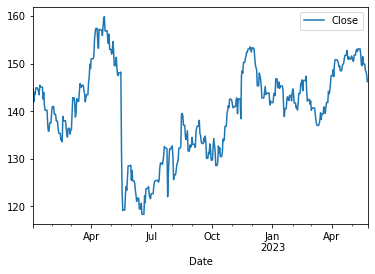

In [8]:
data_2.plot()

In [9]:
# Testing for stationarity
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data_2)

(0.4047493869643195, True)

In [10]:
# Spliting the dataset into train and test
train, test = data_2[:int(len(data_2)*0.9)].copy(), data_2[int(len(data_2)*0.9):].copy()

In [11]:
len(test)

51

In [12]:
train.tail()

,Close
Date,
2023-04-01,147.449997
2023-04-02,147.449997
2023-04-03,148.690002
2023-04-04,147.229996
2023-04-05,149.669998


In [13]:
test.head()

,Close
Date,
2023-04-06,150.800003
2023-04-07,150.800003
2023-04-08,150.800003
2023-04-09,150.800003
2023-04-10,150.509995


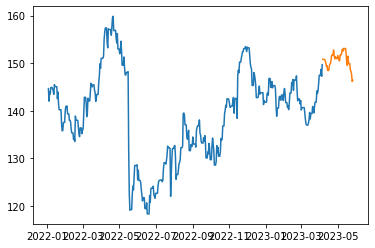

In [14]:
plt.figure()
plt.plot(train)
plt.plot(test)
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/train-test')

In [15]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2108.107, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1985.537, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2106.430, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1929.128, Time=0.34 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1911.361, Time=0.53 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1900.087, Time=1.03 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1894.322, Time=1.97 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=11.69 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1897.604, Time=1.59 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=1896.314, Time=2.50 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=1896.315, Time=3.55 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=1894.444, Time=2.28 sec
 ARIMA(2,1,1)(5,1,0)[12]          

In [16]:
par_map = arima_model.get_params()
a, b, c = par_map['order'][0], par_map['order'][1], par_map['order'][2]

In [17]:
# check the Best model: ARIMA(1,1,1)(5,1,0)[12]
model = sm.tsa.arima.ARIMA(train, order=(a, b, c))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  458
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -916.226
Date:                Tue, 20 Jun 2023   AIC                           1836.452
Time:                        19:02:46   BIC                           1844.702
Sample:                    01-03-2022   HQIC                          1839.702
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0879      0.021      4.092      0.000       0.046       0.130
sigma2         3.2279      0.064     50.769      0.000       3.103       3.353
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [18]:
# Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  458
Model:             SARIMAX(1, 1, 0)x(5, 1, 0, 12)   Log Likelihood                -940.161
Date:                            Tue, 20 Jun 2023   AIC                           1894.322
Time:                                    19:02:46   BIC                           1923.008
Sample:                                01-03-2022   HQIC                          1905.633
                                     - 04-05-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1098      0.030      3.636      0.000       0.051       0.169
ar.S.L12      -0.8099      0.039    -20.731      0.000      -0.886      -0.733
ar.S.L24      -0.6375      0.052    -12.292      0.000      -0.739      -0.536
ar.S.L36      -0.4269      0.055     -7.722      0.000      -0.535      -0.319
ar.S.L48      -0.2817      0.054     -5.176      0.000      -0.388      -0.175
ar.S.L60      -0.1330      0.036     -3.669      0.000      -0.204      -0.062
sigma2         3.9075      0.115     33.852      0.000       3.681       4.134
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3289.73
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 51),index=test.index)
prediction.columns = ['predicted_price']
prediction.tail()

,predicted_price
Date,
2023-05-22,156.256115
2023-05-23,157.143166
2023-05-24,157.271460
2023-05-25,157.445066
2023-05-26,158.712229


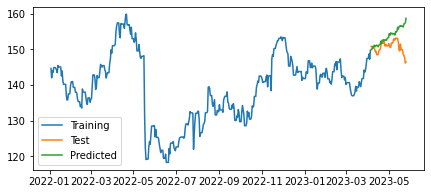

In [20]:
plt.figure(figsize=(7,3))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
# plt.savefig('/Users/jennyhuang/Documents/jobs/DBC-AI-Launch/project1-StockPrediction/test/TimeSeries_Auto-ARIMA/prediction.png')

In [21]:
test['predicted_price'] = prediction
r2_score(test['Close'], test['predicted_price'])

-5.791602859211287

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 7))
prediction.columns = ['predicted_price']
print(prediction.to_latex())
prediction

\begin{tabular}{lr}
\toprule
{} &  predicted\_price \\
\midrule
2023-04-06 &       149.921579 \\
2023-04-07 &       149.903199 \\
2023-04-08 &       150.685145 \\
2023-04-09 &       150.376560 \\
2023-04-10 &       151.010058 \\
2023-04-11 &       151.157910 \\
2023-04-12 &       150.736259 \\
\bottomrule
\end{tabular}



,predicted_price
2023-04-06,149.921579
2023-04-07,149.903199
2023-04-08,150.685145
2023-04-09,150.376560
2023-04-10,151.010058
2023-04-11,151.157910
2023-04-12,150.736259


In [23]:
# final result for future 7 days
prediction = pd.DataFrame(arima_model.predict(n_periods = 58))
prediction.columns = ['predicted_price']
prediction.tail(7)

,predicted_price
2023-05-27,158.106561
2023-05-28,158.839904
2023-05-29,159.133057
2023-05-30,159.209445
2023-05-31,159.583281
2023-06-01,159.496781
2023-06-02,159.524016


In [24]:
real = data.loc['2023-05-26', 'Close']
pred = prediction.loc['2023-06-02', 'predicted_price']
perc = (pred - real) / real * 100
print("The precentage of the future 7th day's price is higher than the prediction day is {0:.2f}%".format(perc))

The precentage of the future 7th day's price is higher than the prediction day is 8.95%


In [25]:
toc = time.time()
print("Total running time is {0:.2f} min".format((toc - tic) / 60))

Total running time is 0.76 min
